In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
          'font.size':13,
         'figure.max_open_warning': 0}

plt.rcParams.update(params)
import matplotlib.colors as colors

In [4]:
import dask.array as da
from daskms import xds_from_table, xds_to_table
from dask.distributed import Client

import numpy as np

In [5]:
client = Client(n_workers=4, 
                threads_per_worker=4, 
                processes=True, 
                memory_limit='8GB'
                )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32835,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:41963,Total threads: 4
Dashboard: http://127.0.0.1:34987/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:41117,


# Setting the data path

In [6]:
data_path = '/media/nadeem/data1/nadeem/GitHub/MeerKAT/RFI/DARA2021/'

# Create xarray datasets from Measurement Set 

In [7]:

ds = xds_from_table("1548939342.ms")

In [8]:
print(ds)

[<xarray.Dataset> Size: 1GB
Dimensions:          (row: 31875, chan: 1024, corr: 2, flagcat: 1, uvw: 3)
Coordinates:
    ROWID            (row) int64 255kB dask.array<chunksize=(10000,), meta=np.ndarray>
Dimensions without coordinates: row, chan, corr, flagcat, uvw
Data variables: (12/24)
    FLAG_ROW         (row) bool 32kB dask.array<chunksize=(10000,), meta=np.ndarray>
    FEED2            (row) int32 128kB dask.array<chunksize=(10000,), meta=np.ndarray>
    OBSERVATION_ID   (row) int32 128kB dask.array<chunksize=(10000,), meta=np.ndarray>
    TIME             (row) float64 255kB dask.array<chunksize=(10000,), meta=np.ndarray>
    FEED1            (row) int32 128kB dask.array<chunksize=(10000,), meta=np.ndarray>
    FLAG             (row, chan, corr) bool 65MB dask.array<chunksize=(10000, 1024, 2), meta=np.ndarray>
    ...               ...
    WEIGHT_SPECTRUM  (row, chan, corr) float32 261MB dask.array<chunksize=(10000, 1024, 2), meta=np.ndarray>
    IMAGING_WEIGHT   (row, chan) flo

# Getting the keys in the MS

In [9]:
i=0
for key in ds[0].keys():
    print(key)

FLAG_ROW
FEED2
OBSERVATION_ID
TIME
FEED1
FLAG
FLAG_CATEGORY
STATE_ID
DATA
PROCESSOR_ID
INTERVAL
SIGMA
FIELD_ID
UVW
WEIGHT
EXPOSURE
ARRAY_ID
TIME_CENTROID
WEIGHT_SPECTRUM
IMAGING_WEIGHT
ANTENNA1
SCAN_NUMBER
DATA_DESC_ID
ANTENNA2


# Some EDA

In [10]:
obs_table = xds_from_table("1548939342.ms::OBSERVATION")
field_table = xds_from_table("1548939342.ms::FIELD")
print(obs_table)
fieldNames = field_table[0].NAME
print("Name of target: " + fieldNames.data.compute()[0])

[<xarray.Dataset> Size: 81B
Dimensions:         (row: 1, log: 1, schedule: 1, obs-exts: 2)
Coordinates:
    ROWID           (row) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: row, log, schedule, obs-exts
Data variables:
    PROJECT         (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    FLAG_ROW        (row) bool 1B dask.array<chunksize=(1,), meta=np.ndarray>
    SCHEDULE_TYPE   (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    TELESCOPE_NAME  (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    RELEASE_DATE    (row) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    LOG             (row, log) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
    SCHEDULE        (row, schedule) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
    TIME_RANGE      (row, obs-exts) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    OBSERVER        (row) object 8B dask.array<chunksize=(1,), meta=

In [93]:
from astropy.time import Time
for key in obs_table[0].keys():

    print(f'{key}: {obs_table[0][key].values}')


print("START AND END TIMES")
print(obs_table[0]["TIME_RANGE"].compute())

start = 5.05565617e+09/86400  #Change MJD from seconds to days
end = 5.05565639e+09/86400
startDate = Time(start, format='mjd').to_datetime()
endDate = Time(end, format='mjd').to_datetime()
print()
print("Start Date: " + str(startDate))
print("End Date: " + str(endDate))

PROJECT: ['20190131-0012']
FLAG_ROW: [False]
SCHEDULE_TYPE: ['unknown']
TELESCOPE_NAME: ['MeerKAT']
RELEASE_DATE: [5.05565639e+09]
LOG: [['unavailable']]
SCHEDULE: [['unavailable']]
TIME_RANGE: [[5.05565617e+09 5.05565639e+09]]
OBSERVER: ['Lindsay']
START AND END TIMES
<xarray.DataArray 'TIME_RANGE' (row: 1, obs-exts: 2)> Size: 16B
array([[5.05565617e+09, 5.05565639e+09]])
Coordinates:
    ROWID    (row) int64 8B 0
Dimensions without coordinates: row, obs-exts

Start Date: 2019-01-31 12:56:10
End Date: 2019-01-31 12:59:50


In [12]:
A1 = ds[0]["ANTENNA1"]
A2 = ds[0]["ANTENNA2"]
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)
inter = ds[0]["INTERVAL"]
print(f'Total number of antennas used {nants}')
print('Interval Table Shape: ',inter.shape)
print(f'Dump rate is {np.median(inter)} s')

Total number of antennas used 50
Interval Table Shape:  (31875,)
Dump rate is 7.9966169712 s


# Understanding the UV coverage

In [13]:
# Get the UVW points
ds[0]['UVW']


<xarray.DataArray 'UVW' (row: 31875, uvw: 3)> Size: 765kB
dask.array<read~UVW~1548939342.ms, shape=(31875, 3), dtype=float64, chunksize=(10000, 3), chunktype=numpy.ndarray>
Coordinates:
    ROWID    (row) int64 255kB dask.array<chunksize=(10000,), meta=np.ndarray>
Dimensions without coordinates: row, uvw

In [14]:
u,v,w = ds[0]['UVW'][:,0],ds[0]['UVW'][:,1],ds[0]['UVW'][:,2]

{'__daskms_partition_schema__': ()}
The max baseline length is: 7697.57998251673
The min baseline length is: 29.256520999599363
4874
29376


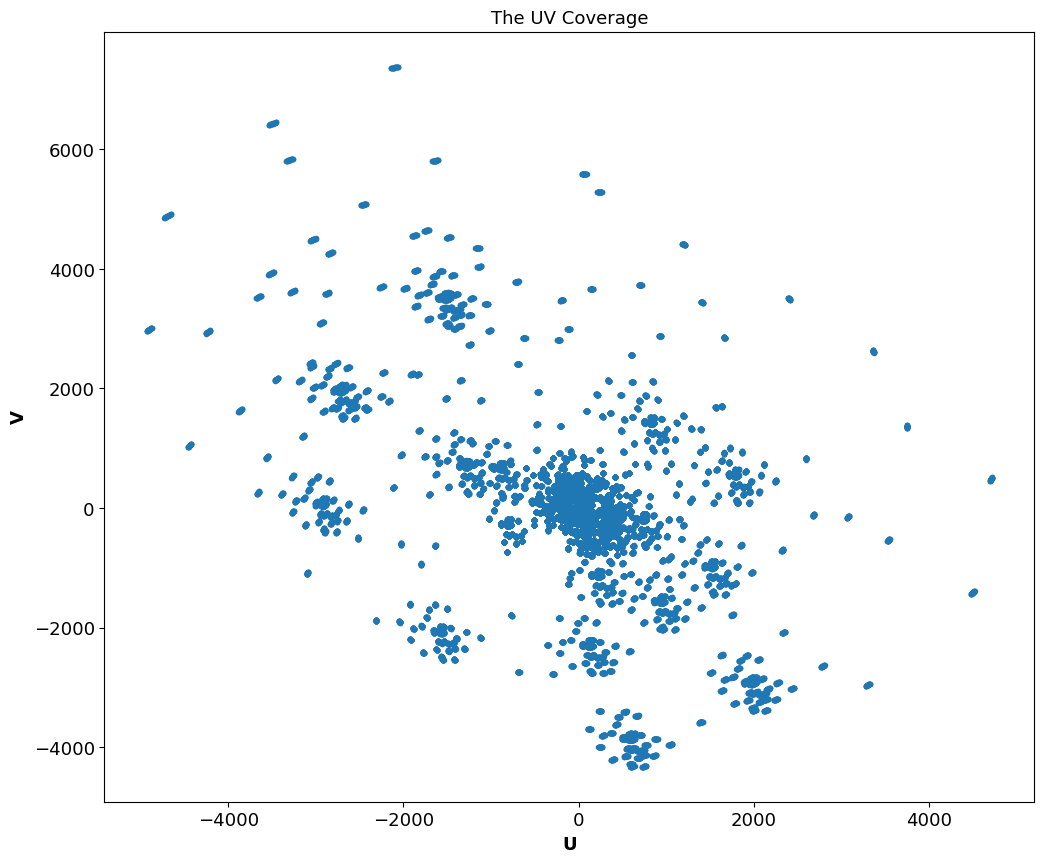

In [98]:
plt.title("The UV Coverage")
plt.plot(u,v,'.')
plt.xlabel('U')
plt.ylabel('V')

baselineLength = np.sqrt(u.data.compute()**2 + v.data.compute()**2 + w.data.compute()**2)
maxLength = baselineLength.max()

#min length cannot be zero, or else its from the same antenna
minLength = 10000 # choose arbitrary number to start
minIndex = 0
for i in range(len(baselineLength)):
    if baselineLength[i] < minLength and baselineLength[i] != 0: #gets smallest number from array that is nonzero
        minLength = baselineLength[i]
        minIndex = i

maxIndex = np.argmax(baselineLength)

print('The max baseline length is: ' + str(maxLength))
print('The min baseline length is: ' + str(minLength))

print(maxIndex)
print(minIndex)


In [96]:

# Read the ANTENNA table
antenna_table = xds_from_table("1548939342.ms::ANTENNA")

#print(antenna_table)
antennaNames = antenna_table[0]['NAME'].data.compute()

minIndex1 = A1[minIndex]
minIndex2 = A2[minIndex]

maxIndex1 = A1[maxIndex]
maxIndex2 = A2[maxIndex]

minAntenna1 = antennaNames[minIndex1]
minAntenna2 = antennaNames[minIndex2]

maxAntenna1 = antennaNames[maxIndex1]
maxAntenna2 = antennaNames[maxIndex2]

#get names
print('Min')
print(minAntenna1 + ' & ' + minAntenna2)

print()
print('Max')
print(maxAntenna1 + ' & ' + maxAntenna2)
print()

#resolution: theta = 1.22 * lambda/D
#get lambda

specWindow = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")
for key in specWindow[0].keys():
    print(f'{key}: {specWindow[0][key].values}')
print()

freq = 1.284e9 #Hz
c = 3e8

minRes = 1.22 * (c/freq)/minLength * (3600 * 180)/np.pi

maxRes = 1.22 * (c/freq)/maxLength * (3600 * 180)/np.pi

print('The expected resolution for the short baseline is: ' + str(round(minRes, 2)) + ' arcsec')
print('The expected resolution for the long baseline is: ' + str(round(maxRes, 2)) + ' arcsec')
print()


#get delay
#assume source is at zenith so maximum delay is t = length/c

minDelay = minLength/c
maxDelay = maxLength/c

print('Delay time for short baseline: ' + str(minDelay) + ' seconds')
print('Delay time for long baseline: ' + str(maxDelay) + ' seconds')

[<xarray.Dataset> Size: 5kB
Dimensions:        (row: 50, xyz: 3)
Coordinates:
    ROWID          (row) int64 400B dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: row, xyz
Data variables:
    NAME           (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    FLAG_ROW       (row) bool 50B dask.array<chunksize=(50,), meta=np.ndarray>
    DISH_DIAMETER  (row) float64 400B dask.array<chunksize=(50,), meta=np.ndarray>
    POSITION       (row, xyz) float64 1kB dask.array<chunksize=(50, 3), meta=np.ndarray>
    MOUNT          (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    OFFSET         (row, xyz) float64 1kB dask.array<chunksize=(50, 3), meta=np.ndarray>
    STATION        (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    TYPE           (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    __daskms_partition_schema__:  ()]
Min
m000 & m002

Max
m048 & m060

MEAS_FREQ_REF: [5]
NAME: ['none'

In [17]:
antenna_table[0]

<xarray.Dataset> Size: 5kB
Dimensions:        (row: 50, xyz: 3)
Coordinates:
    ROWID          (row) int64 400B dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: row, xyz
Data variables:
    NAME           (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    FLAG_ROW       (row) bool 50B dask.array<chunksize=(50,), meta=np.ndarray>
    DISH_DIAMETER  (row) float64 400B dask.array<chunksize=(50,), meta=np.ndarray>
    POSITION       (row, xyz) float64 1kB dask.array<chunksize=(50, 3), meta=np.ndarray>
    MOUNT          (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    OFFSET         (row, xyz) float64 1kB dask.array<chunksize=(50, 3), meta=np.ndarray>
    STATION        (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
    TYPE           (row) object 400B dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    __daskms_partition_schema__:  ()

In [18]:
antenna_table[0]['NAME'].values

array(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm009', 'm010',
       'm011', 'm013', 'm014', 'm015', 'm017', 'm019', 'm020', 'm021',
       'm022', 'm023', 'm024', 'm025', 'm027', 'm028', 'm029', 'm031',
       'm032', 'm033', 'm035', 'm037', 'm038', 'm039', 'm040', 'm041',
       'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049',
       'm050', 'm051', 'm055', 'm056', 'm057', 'm058', 'm059', 'm060',
       'm061', 'm062'], dtype=object)

In [19]:
antenna_table[0]['DISH_DIAMETER'].values

array([13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5,
       13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5,
       13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5,
       13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5,
       13.5, 13.5, 13.5, 13.5, 13.5, 13.5])

In [20]:
antenna_table[0]['POSITION']

<xarray.DataArray 'POSITION' (row: 50, xyz: 3)> Size: 1kB
dask.array<read~POSITION~1548939342.ms/ANTENNA, shape=(50, 3), dtype=float64, chunksize=(50, 3), chunktype=numpy.ndarray>
Coordinates:
    ROWID    (row) int64 400B dask.array<chunksize=(50,), meta=np.ndarray>
Dimensions without coordinates: row, xyz

In [21]:
print(antenna_table[0]['POSITION'].values)

[[ 5109224.28330101  2006790.34830945 -3239100.60432023]
 [ 5109237.64002439  2006805.67700518 -3239069.99463992]
 [ 5109224.98529035  2006765.00133159 -3239115.19822119]
 [ 5109247.71453184  2006736.9651357  -3239096.13442916]
 [ 5109244.68809625  2006674.4233089  -3239139.81459295]
 [ 5109222.76106102  2006688.94849795 -3239165.94167899]
 [ 5109132.82118802  2006798.06539449 -3239242.19060095]
 [ 5109046.34250297  2006823.98222895 -3239363.79206003]
 [ 5109122.96650556  2006849.69137709 -3239225.88024209]
 [ 5109048.21915394  2006984.47473988 -3239261.95549118]
 [ 5109082.89642682  2007045.23603689 -3239169.09259079]
 [ 5109139.53273202  2006992.24816646 -3239111.37666584]
 [ 5109193.73983259  2007001.70002865 -3239019.08733502]
 [ 5109122.95791977  2006942.91666107 -3239168.36029351]
 [ 5109142.92017108  2006871.50044504 -3239180.65456621]
 [ 5109272.06096906  2006500.0158821  -3239203.48775662]
 [ 5109454.06397737  2006488.737612   -3238920.41294648]
 [ 5109368.62411322  2006509.64

In [22]:
X,Y,Z = antenna_table[0]['POSITION'][:,0],antenna_table[0]['POSITION'][:,1],antenna_table[0]['POSITION'][:,2]

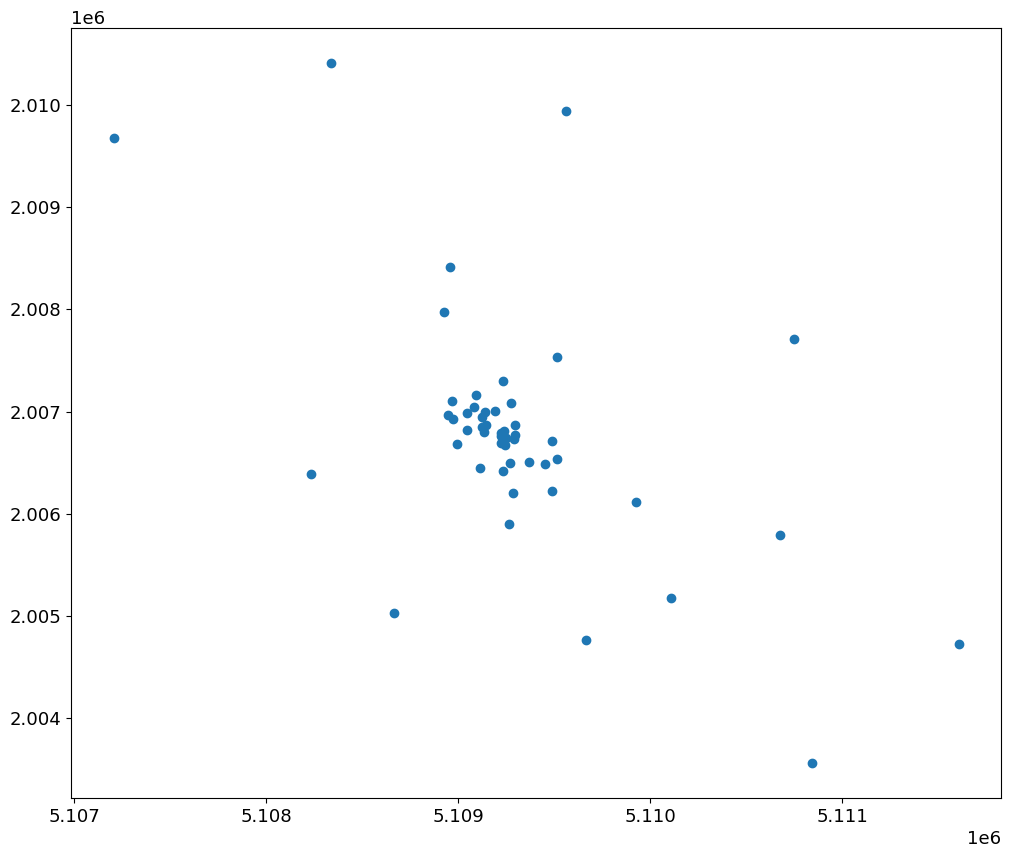

In [23]:
plt.plot(X,Y, 'o')

In [24]:

# Read the SPECTRAL table
spectral_table = xds_from_table("1548939342.ms::SPECTRAL_WINDOW")

In [25]:
spectral_table[0]

<xarray.Dataset> Size: 33kB
Dimensions:          (row: 1, chan: 1024)
Coordinates:
    ROWID            (row) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: row, chan
Data variables: (12/14)
    MEAS_FREQ_REF    (row) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    NAME             (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    CHAN_WIDTH       (row, chan) float64 8kB dask.array<chunksize=(1, 1024), meta=np.ndarray>
    RESOLUTION       (row, chan) float64 8kB dask.array<chunksize=(1, 1024), meta=np.ndarray>
    FLAG_ROW         (row) bool 1B dask.array<chunksize=(1,), meta=np.ndarray>
    NUM_CHAN         (row) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    ...               ...
    IF_CONV_CHAIN    (row) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    TOTAL_BANDWIDTH  (row) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    REF_FREQUENCY    (row) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    EFFECTIVE_BW     (row, chan) float64 8kB dask.array<chunksize=(1, 1024), meta=np.ndarray>
    CHAN_FREQ        (row, chan) float64 8kB dask.array<chunksize=(1, 1024), meta=np.ndarray>
    NET_SIDEBAND     (row) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    __daskms_partition_schema__:  ()

In [26]:
frequencies = spectral_table[0]['CHAN_FREQ'].values
nchannels = spectral_table[0]['NUM_CHAN'].values[0]
channel_width = spectral_table[0]['CHAN_WIDTH'].values[0][0]


summary = {
    'Frequencies': frequencies,
    'No_Channeles': nchannels,
    'Channel_Width': channel_width,
    }

In [27]:
print(f"Frequency range (MHz): {summary['Frequencies'].min()/1.e6} - {summary['Frequencies'].max()/1.e6}")  
print(f"Total no of channels {summary['No_Channeles']}")
print(f"Channel width (kHz): {channel_width/1.e3}")

Frequency range (MHz): 856.0 - 1711.1640625
Total no of channels 1024
Channel width (kHz): 835.9375


# Working with Visibilities

In [28]:
# Let us now try to get the visibilities
vis = ds[0]['DATA']

In [29]:
vis.shape

(31875, 1024, 2)

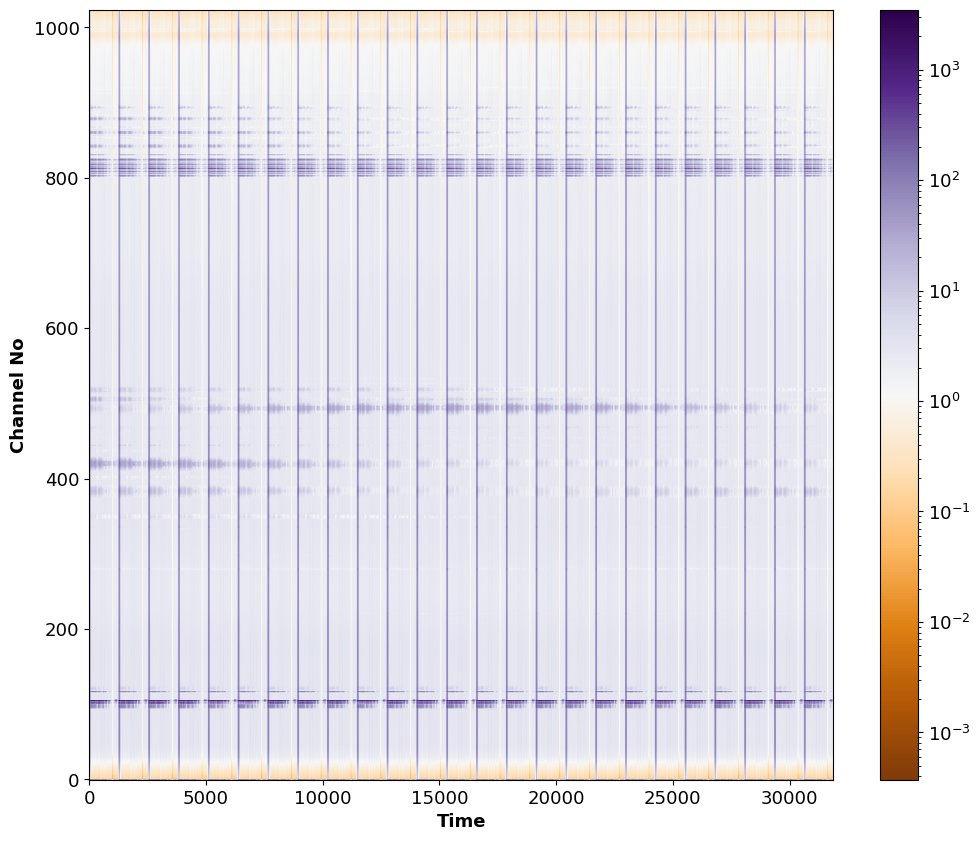

In [30]:
plt.imshow(np.abs(vis[:,:,0]).T, 
           aspect= 'auto', 
           origin='lower', 
           cmap='PuOr', 
           norm = colors.LogNorm()
           )
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()

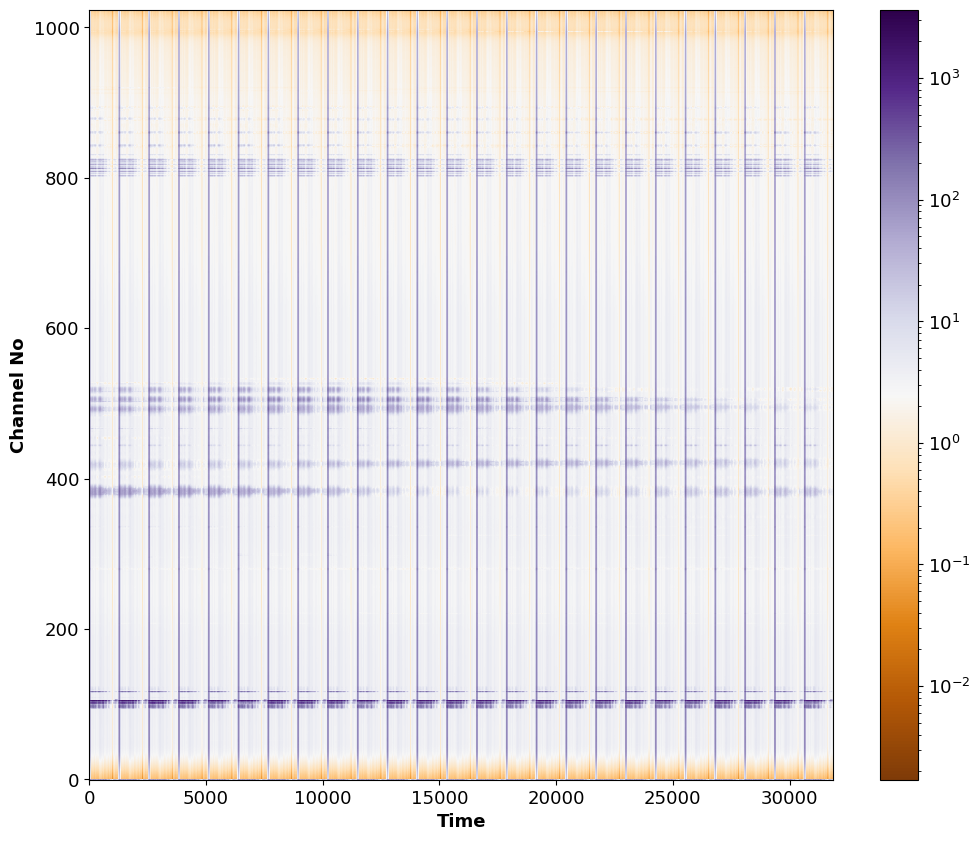

In [31]:
plt.imshow(np.abs(vis[:,:,1]).T, 
           aspect= 'auto', 
           origin='lower', 
           cmap='PuOr', 
           norm = colors.LogNorm()
           )
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()

Text(0.5, 0, 'Channels')

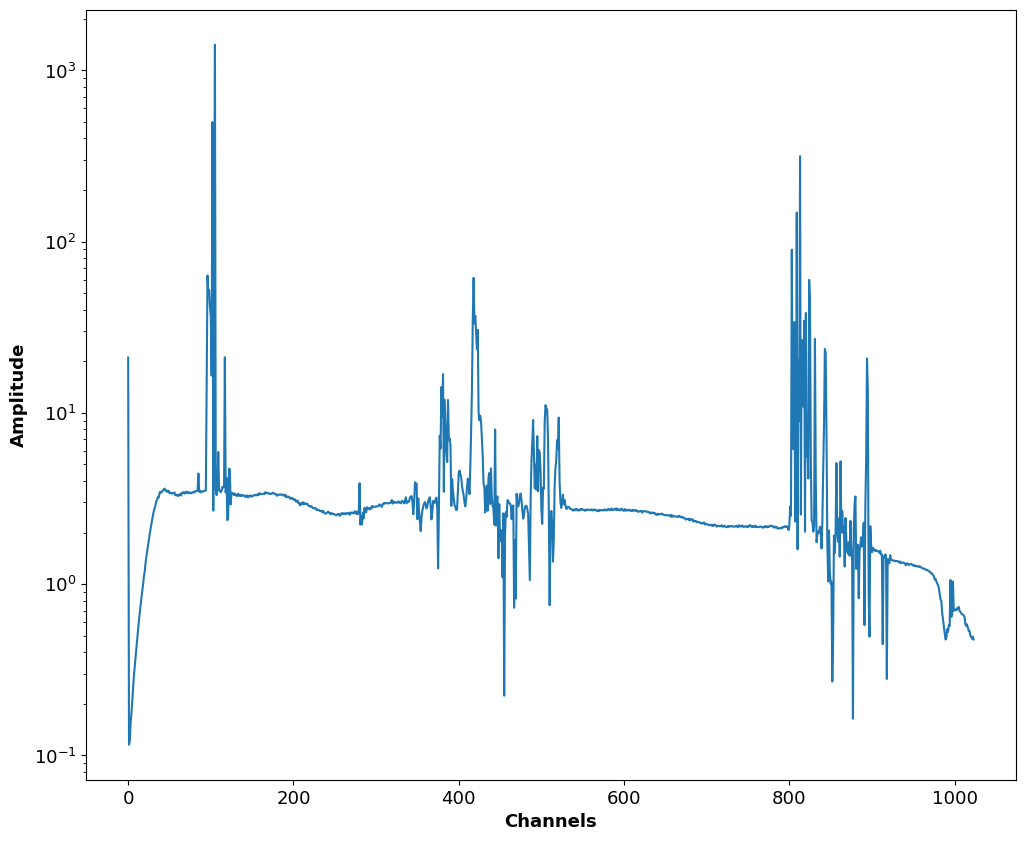

In [32]:
# Doing a 1-D cut across the visibility 

plt.plot(np.abs(vis[500,:,0]))
plt.semilogy()
plt.ylabel('Amplitude')
plt.xlabel('Channels')

In [33]:
phaset2selected = np.angle(vis[500,:,0].T)


Text(0.5, 0, 'Channel')

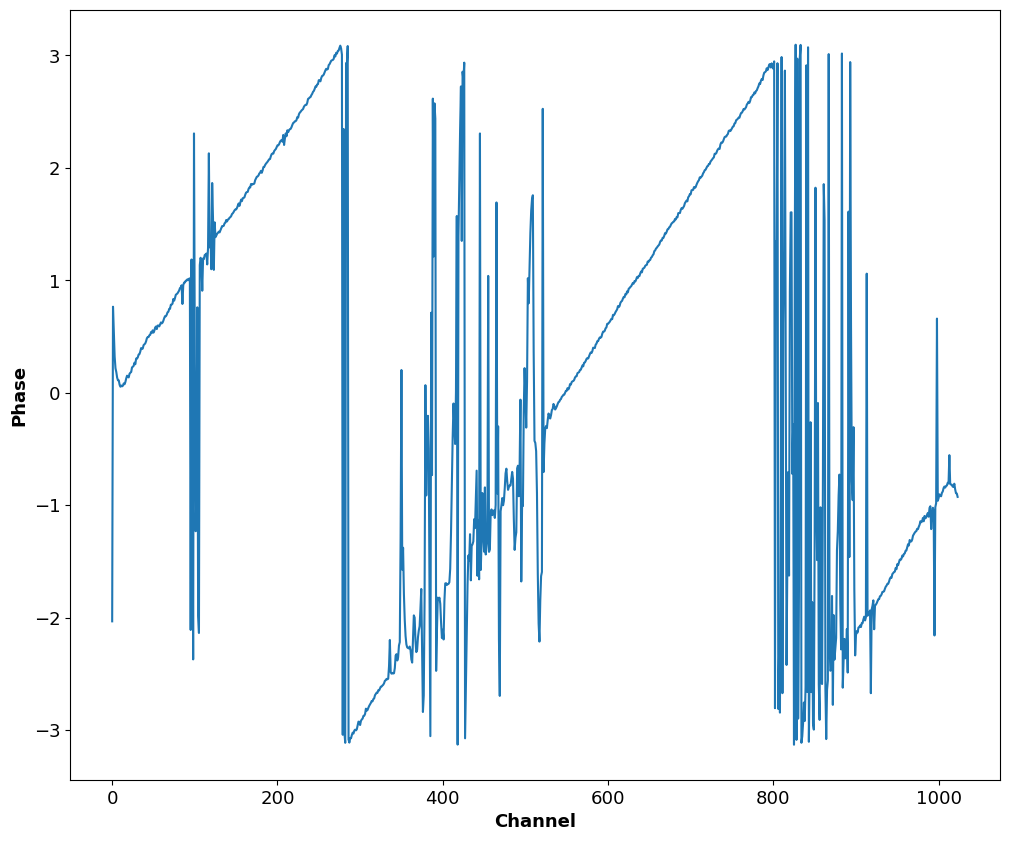

In [34]:
plt.plot(phaset2selected)
plt.ylabel('Phase')
plt.xlabel('Channel')



Text(0.5, 0, 'Channel')

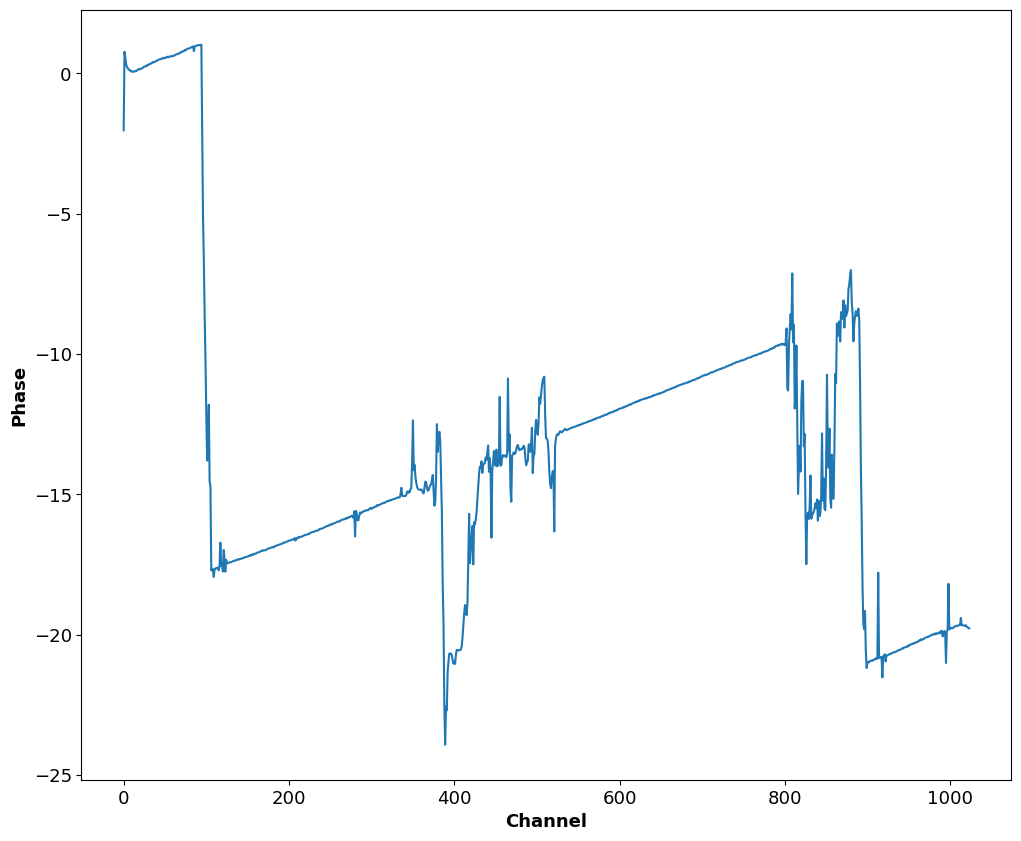

In [35]:
plt.plot(np.unwrap(phaset2selected))
plt.ylabel('Phase')
plt.xlabel('Channel')



In [36]:
def Gauss(x, dc, a, x0, sigma):
    '''
    This will fit a gaussian function to a data set
    '''
    return dc+a * np.exp(-(x - x0)**2 / (2 * sigma**2))


/tmp/ipykernel_5085/3455234846.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_xticks(np.arange(frequencies[0]/1.e6,frequencies[-1]/1.e6, step=100))


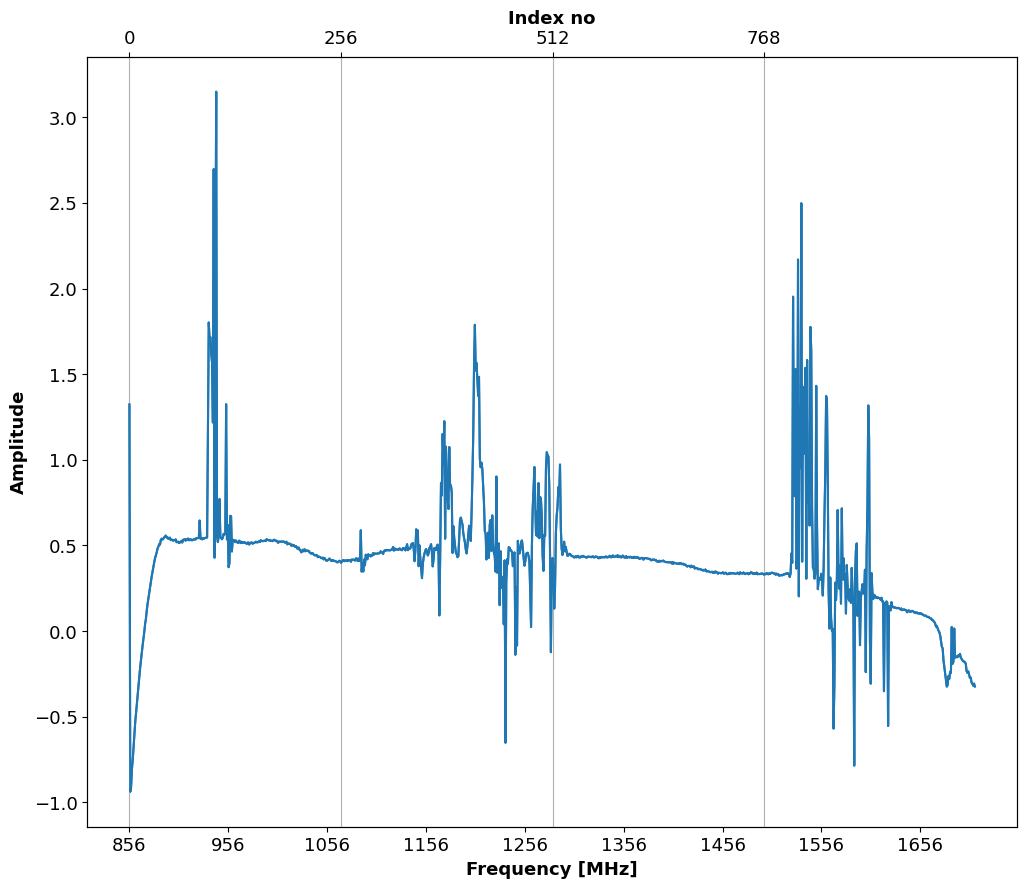

In [37]:
#
# Plot the average across frequency slice
#
frequencies = spectral_table[0]['CHAN_FREQ'].values.T
absdata = np.abs(vis[500,:,0]).compute()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(frequencies/1.e6,np.log10(absdata),'-')
ax1.set_xticks(np.arange(frequencies[0]/1.e6,frequencies[-1]/1.e6, step=100))
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Amplitude')

ax2.plot(np.log10(absdata))
ax2.set_xticks(np.arange(0,absdata.shape[0], step=256))
ax2.set_xlabel('Index no')
plt.grid()


In [38]:
from scipy.optimize import curve_fit, minimize_scalar

/tmp/ipykernel_5085/3343365857.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)


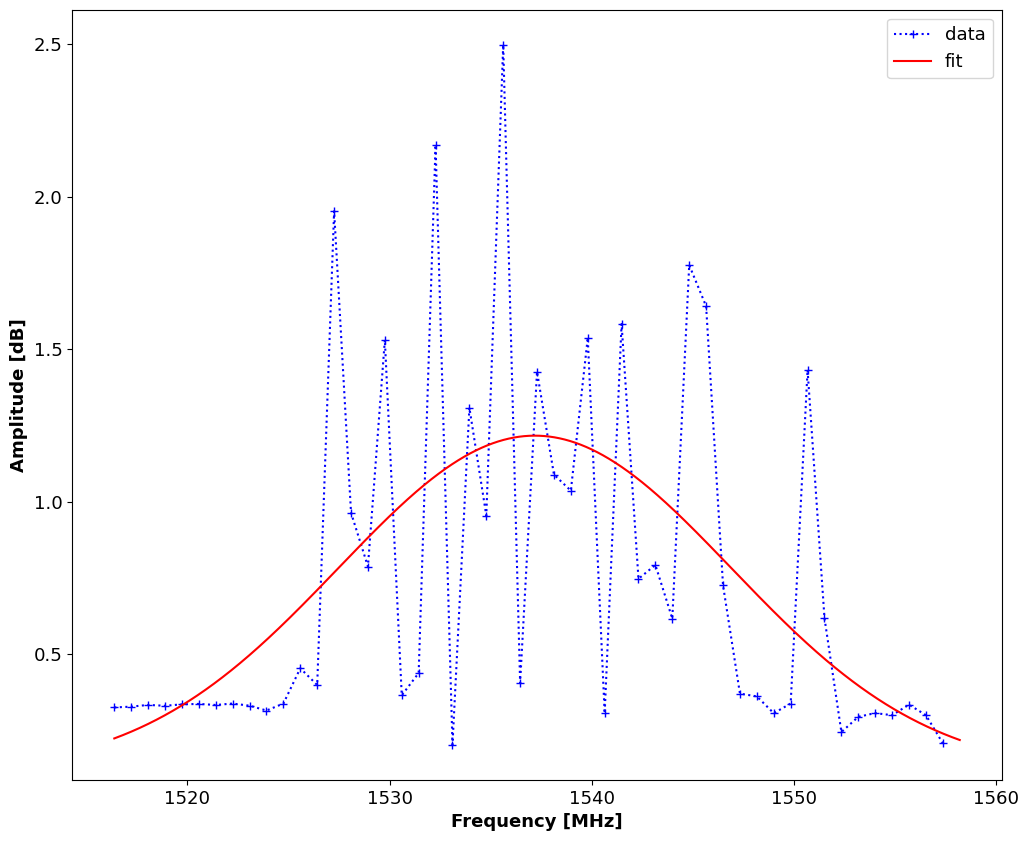

FWHM [MHz] =  22.15900294187035
Maximum amplitude is at [db], 1.216373233724882 
Maximum is at [MHz]  1537.181375
Number of channels affected 26


In [71]:
# 350 - 400 good spike
# Use 50-150 for 1548939342.ms
ini_idx = 790  #int(input('Enter initial index for Gaussian fit '))
fin_idx = 840 #int(input('Enter final index for Gaussian fit '))

x = np.ravel(frequencies[ini_idx:fin_idx])
y = np.log10(absdata[ini_idx:fin_idx])

# weighted arithmetic mean (corrected - check the section below)
mean = (sum(x * y) / sum(y)).values
sigma = (np.sqrt(sum(y * (x - mean)**2) / sum(y))).values

dc = np.nanmean(np.log10(absdata[550:750]).values)-1



popt,pcov = curve_fit(Gauss, x, y, p0=[2.9, dc, mean, sigma])
x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)
p0=[dc, 2.9, mean, sigma]
yGuess = Gauss(x_new, *p0)

plt.plot(x/1e6, y, 'b+:', label='data')
plt.plot(x_new/1e6, Gauss(x_new, *popt), 'r-', label='fit')
plt.legend()

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.show()

print (f"FWHM [MHz] =  {(2.*np.sqrt(2.*np.log(2.))*sigma)/1.e6}")
print(f"Maximum amplitude is at [db], {max(Gauss(x_new, *popt))} ")
print (f"Maximum is at [MHz]  {x_new[np.argmax(Gauss(x_new, *popt))]/1.e6}")
print(f"Number of channels affected {int(((2.*np.sqrt(2.*np.log(2.))*sigma))/(channel_width))}")

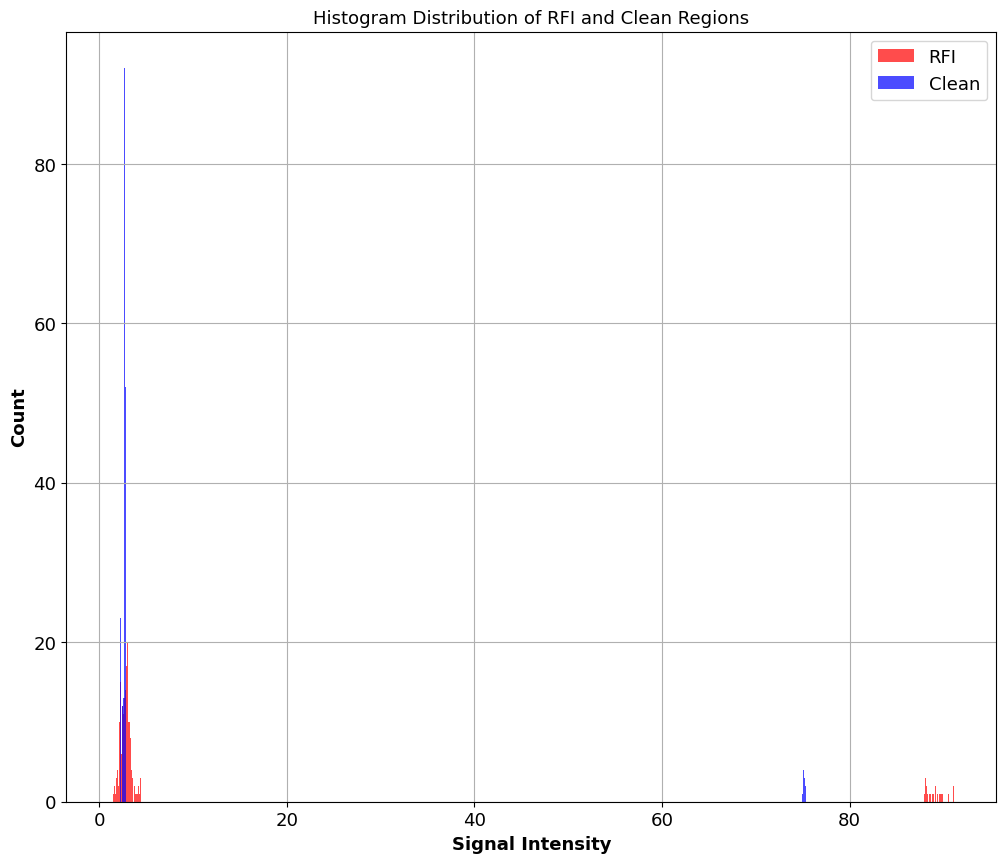

In [40]:
vis_clean = []

vis_rfi = []

for a1 in range(0,10):

   for a2 in range(1,10):

      #print(antenna_table[0].NAME.data[a1].compute(), antenna_table[0].NAME.data[a2].compute())

      idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]

      #antenna_table[0].NAME.data[a1].compute(), antenna_table[0].NAME.data[a2].compute()

   vis_rfi.append(np.abs(ds[0].DATA.data[idx][:,400,0].compute()))

   vis_clean.append(np.abs(ds[0].DATA.data[idx][:,600,0].compute()))

combined_array_clean = np.concatenate(vis_clean)

combined_array_rfi = np.concatenate(vis_rfi)

plt.hist(combined_array_rfi, bins=1000, alpha=0.7, color='red', label='RFI')
plt.hist(combined_array_clean, bins=1000, alpha=0.7, color='blue', label='Clean')

plt.xlabel('Signal Intensity')
plt.ylabel('Count')
plt.title('Histogram Distribution of RFI and Clean Regions')
plt.legend()
plt.grid(True)
#plt.xlim(0, 10)
plt.show()



In [41]:
from scipy.stats import kurtosis, skew

rfiSTD = np.std(combined_array_rfi)
cleanSTD = np.std(combined_array_clean)

rfiVar = np.var(combined_array_rfi)
cleanVar = np.var(combined_array_clean)

rfiSkew = skew(combined_array_rfi)
cleanSkew = skew(combined_array_clean)

rfiKurtosis = kurtosis(combined_array_rfi)
cleanKurtosis = kurtosis(combined_array_clean)

print("RFI Data - STD: " + str(rfiSTD) + ", Var: " + str(rfiVar))
print("Clean Data - STD: " + str(cleanSTD) + ", Var: " + str(cleanVar))
print()
print("RFI Data - Skewness: " + str(rfiSkew) + ", Kurtosis: " + str(rfiKurtosis))
print("Clean Data - Skewness: " + str(cleanSkew) + ", Kurtosis: " + str(cleanKurtosis))



RFI Data - STD: 25.95494, Var: 673.659
Clean Data - STD: 21.767574, Var: 473.82727

RFI Data - Skewness: 2.665302210028127, Kurtosis: 5.10992924846142
Clean Data - Skewness: 2.666007732547352, Kurtosis: 5.109089763537858


In [42]:

# Generate fake data
# rng = np.random.default_rng(0)
# x = np.linspace(-5., 5., 200)
# y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
# y += rng.normal(0., 0.2, x.shape)

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.


# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'k-+')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)

NameError: name 'models' is not defined